<a href="https://colab.research.google.com/github/joaopedrodecesaro/lscp_uem_python/blob/main/ODEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import timeit

In [7]:
# Plotting function
def plot_concentration_over_time(conc_data, labels, t, colors, linestyles=None,
                                 y_label="Concentration (mol/L)", max_value=None, min_value=None, tick=None):
    plt.figure(figsize=(6,4))

    for i in range(conc_data.shape[1]):
        if linestyles is None:
            plt.plot(t, conc_data[:,i], label=labels[i], color=colors[i])
        else:
            plt.plot(t, conc_data[:,i], label=labels[i], color=colors[i], linestyle=linestyles[i])

    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(np.arange(0, 50+1e-6, 5), fontsize=12)
    plt.yticks(fontsize=12)

    if max_value is None:
        max_value = conc_data.max()
        min_value = conc_data.min()
        buffer_ratio = 0.15
        y_range = max_value - min_value
        max_value_buffered = max_value + buffer_ratio*y_range
        min_value_buffered = max(0, min_value - buffer_ratio*y_range)
        plt.ylim(min_value_buffered, max_value_buffered)
    else:
        plt.ylim(min_value, max_value)
        plt.yticks(np.arange(min_value, max_value+1e-6, tick), fontsize=12)

    plt.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
    plt.tight_layout()
    plt.show()


This example considers that both CSTR reactors begin full with concentrations in the tank beginning at 0

In [8]:
# Parameters
k = 2.0
tau1 = 3.0 # Reactor volume / volumetric flow rate
tau2 = 5.0
CA0 = 1.0
CB0 = 1.0
CC0 = 0.0

# RHS function
def rhs(t, y):
    #y no tempo t
    CA1, CB1, CC1, CA2, CB2, CC2 = y

    # reaction rates
    r1 = k * CA1**2 * CB1
    r2 = k * CA2**2 * CB2

    # Reactor 1 balances
    dCA1 = (CA0 - CA1)/(tau1) - 2*r1
    dCB1 = (CB0 - CB1)/(tau1) - r1
    dCC1 = (0 - CC1)/(tau1) + r1

    # Reactor 2 balances (feed = outlet from R1)
    dCA2 = (CA1 - CA2)/(tau2) - 2*r2
    dCB2 = (CB1 - CB2)/(tau2) - r2
    dCC2 = (CC1 - CC2)/(tau2) + r2

    return [dCA1, dCB1, dCC1, dCA2, dCB2, dCC2]

In [9]:
# Initial condition and integration
y0 = [0, 0, 0, 0, 0, 0]
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 200)

#Call solve_ivp to estimate ODEs using Runge Kutta
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval)

# Extract concentrations
CA1, CB1, CC1, CA2, CB2, CC2 = sol.y.T[:,0], sol.y.T[:,1], sol.y.T[:,2], sol.y.T[:,3], sol.y.T[:,4], sol.y.T[:,5]

(200, 6)


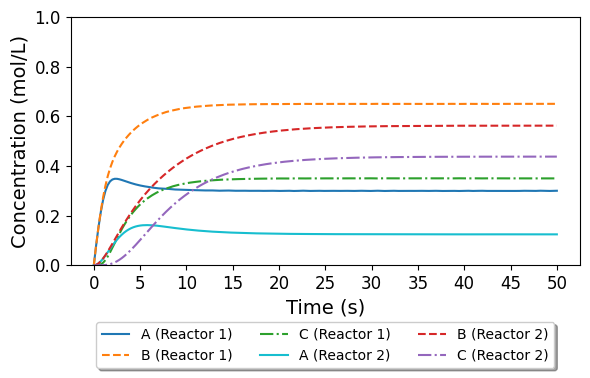

In [5]:
# Data stack: [time points, concentrations]
conc_data = np.vstack([CA1, CB1, CC1, CA2, CB2, CC2]).T

print (conc_data.shape)

labels = ["A (Reactor 1)", "B (Reactor 1)", "C (Reactor 1)",
          "A (Reactor 2)", "B (Reactor 2)", "C (Reactor 2)"]

colors = ["tab:blue", "tab:orange", "tab:green",
          "tab:cyan", "tab:red", "tab:purple"]

linestyles = ["-", "--", "-.", "-", "--", "-."]

plot_concentration_over_time(conc_data, labels, sol.t, colors, linestyles, max_value=1, min_value=0, tick=0.2)

It is possible to estimate through other methods as well:

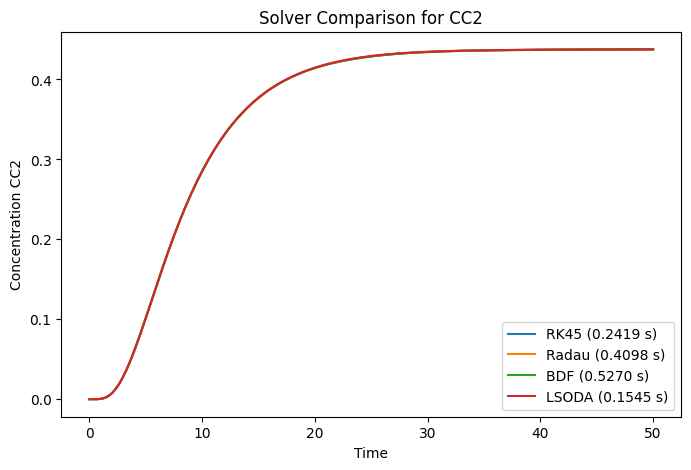

Solver runtimes (total over 25 runs):
RK45  : 0.241906 s
Radau : 0.409766 s
BDF   : 0.526975 s
LSODA : 0.154505 s


In [108]:
solvers = ["RK45", "Radau", "BDF", "LSODA"]
results = {}
n_runs = 25

# Benchmark each solver with timeit
for method in solvers:
    def run_solver():
        solve_ivp(rhs, t_span, y0, t_eval=t_eval, method=method)

    elapsed = timeit.timeit(run_solver, number=n_runs)  # average of n_runs
    sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method=method)  # final solution
    results[method] = {"solution": sol, "time": elapsed}

# Plot comparison for CC2
plt.figure(figsize=(8,5))
for method, data in results.items():
    CC2 = data["solution"].y[5]
    plt.plot(t_eval, CC2, label=f"{method} ({data['time']:.4f} s)")
plt.xlabel("Time")
plt.ylabel("Concentration CC2")
plt.title("Solver Comparison for CC2")
plt.legend()
plt.show()

# Print runtime summary
print(f"Solver runtimes (total over {n_runs} runs):")
for method, data in results.items():
    print(f"{method:6s}: {data['time']:.6f} s")

Let's make a comparison between solving the problem 25 times consecutively or within the same call


Initial concentration is varied

In [109]:
# Parameters
k = 2.0
tau1 = 3.0 # Reactor volume / volumetric flow rate
tau2 = 5.0

#Create all possible values for CA0 and CB0
CA0 = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
CB0 = np.array([1.0, 1.5, 2.0, 2.5, 3.0])

# Create meshgrid
CA_grid, CB_grid = np.meshgrid(CA0, CB0, indexing='ij')

# Flatten to get all pairings
CA0 = CA_grid.ravel()
CB0 = CB_grid.ravel()

print("CA_pairs:", CA0)
print("CB_pairs:", CB0)

# Create C initial concentrations
CC0 = np.zeros(CA0.shape)

print ("CC pairs: ", CC0)


CA_pairs: [1.  1.  1.  1.  1.  1.5 1.5 1.5 1.5 1.5 2.  2.  2.  2.  2.  2.5 2.5 2.5
 2.5 2.5 3.  3.  3.  3.  3. ]
CB_pairs: [1.  1.5 2.  2.5 3.  1.  1.5 2.  2.5 3.  1.  1.5 2.  2.5 3.  1.  1.5 2.
 2.5 3.  1.  1.5 2.  2.5 3. ]
CC pairs:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [110]:
# Create a dictionary containing Concentration names as keys to facilitate code understanding
loc = {"A0": 0, "B0": 1, "C0": 2, "A1": 3, "B1": 4, "C1": 5, "A2": 6, "B2": 7, "C2": 8}

# RHS function
def rhs_vector(t, y):
    num_equations = int(len(y0)/len(CA0))
    num_combinations = len(CA0)
    C = y.reshape(num_equations, num_combinations)

    # reaction rates
    r1 = k * C[loc['A1']]**2 * C[loc['B1']]
    r2 = k * C[loc['A2']]**2 * C[loc['B2']]

    dC = np.zeros((num_equations, num_combinations))

    # Reactor 1 balances
    dC[loc['A1']] = (C[loc['A0']] - C[loc['A1']])/(tau1) - 2*r1
    dC[loc['B1']] = (C[loc['B0']] - C[loc['B1']])/(tau1) - r1
    dC[loc['C1']] = (C[loc['C0']] - C[loc['C1']])/(tau1) + r1

    # Reactor 2 balances (feed = outlet from R1)
    dC[loc['A2']] = (C[loc['A1']] - C[loc['A2']])/(tau2) - 2*r2
    dC[loc['B2']] = (C[loc['B1']] - C[loc['B2']])/(tau2) - r2
    dC[loc['C2']] = (C[loc['C1']] - C[loc['C2']])/(tau2) + r2

    ode_rate = np.concatenate([vector for vector in dC], axis=0)

    return ode_rate

In [111]:
# Initial condition and integration
num_combinations = len(CA0)
CA1_0 = np.zeros(num_combinations)
CB1_0 = np.zeros(num_combinations)
CC1_0 = np.zeros(num_combinations)
CA2_0 = np.zeros(num_combinations)
CB2_0 = np.zeros(num_combinations)
CC2_0 = np.zeros(num_combinations)
y_values = [CA0, CB0, CC0, CA1_0, CB1_0, CC1_0, CA2_0, CB2_0, CC2_0]

# Create a vector with all initial concentration values
y0 = np.concatenate([vector for vector in y_values], axis=0)

t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 200)

#Call solve_ivp to estimate ODEs using Runge Kutta
sol = solve_ivp(rhs_vector, t_span, y0, t_eval=t_eval)

# Extract concentrations from solution
# Create matrix at the shape num_times, num_combinations, num_concentrations (6)
conc_data = sol.y.T.reshape(len(sol.t), num_combinations, 9)

In [112]:
# Remove C0
conc_data_new = conc_data[:, :, 3:]

CA0 =  1.0
CB0 =  1.0


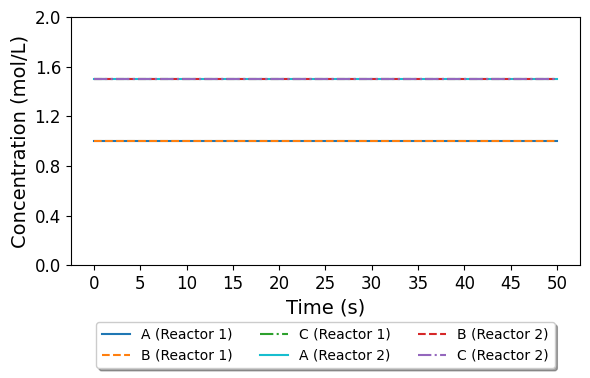

CA0 =  1.5
CB0 =  2.0


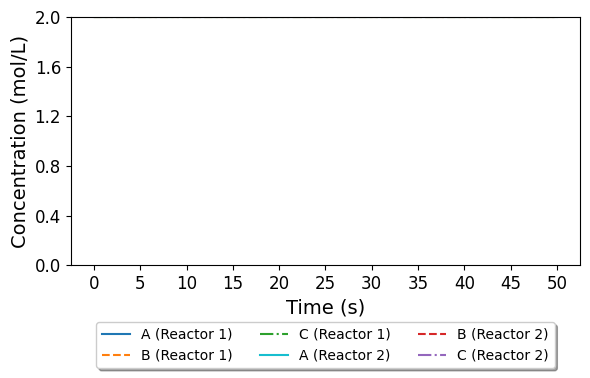

CA0 =  2.5
CB0 =  2.5


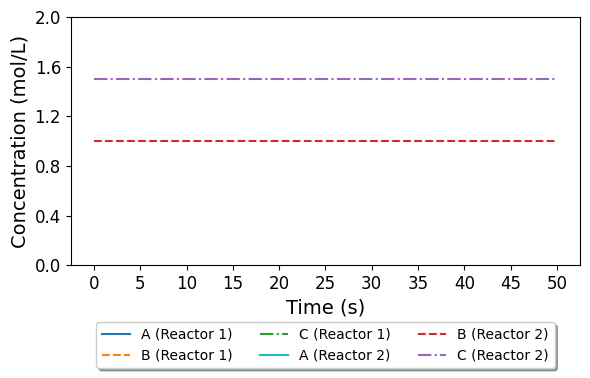

CA0 =  2.0
CB0 =  2.5


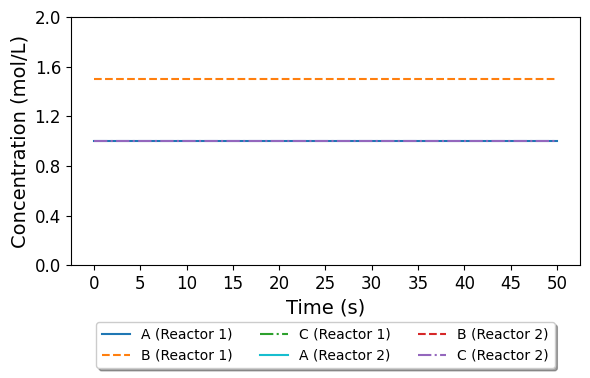

CA0 =  1.5
CB0 =  2.0


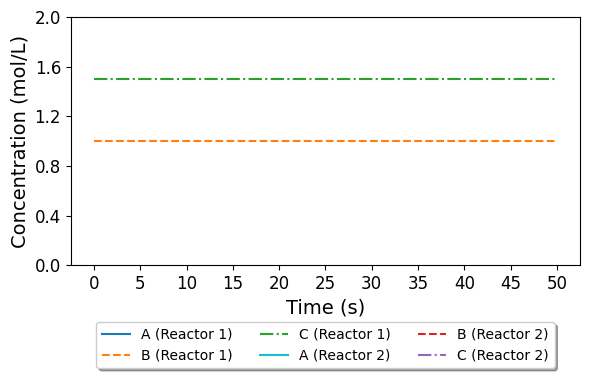

CA0 =  1.0
CB0 =  1.5


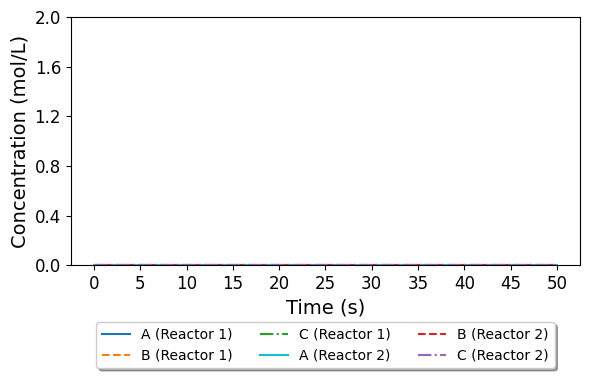

CA0 =  0.0
CB0 =  0.0


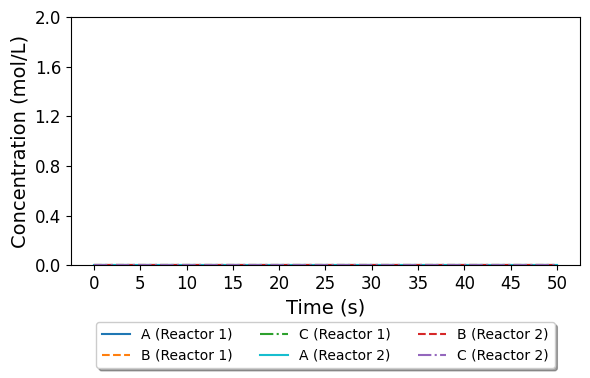

CA0 =  0.0
CB0 =  0.0


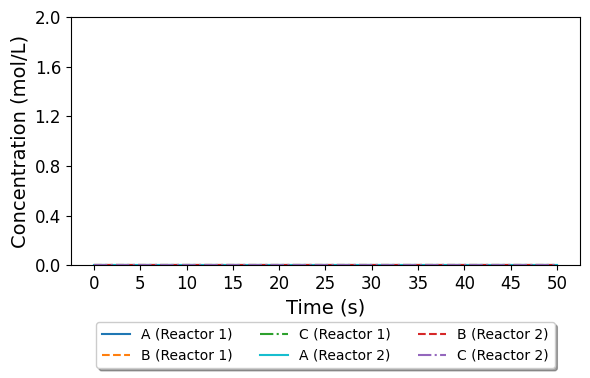

CA0 =  0.0
CB0 =  0.0


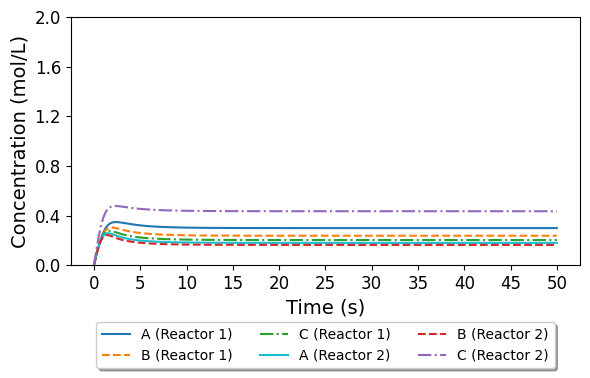

CA0 =  0.0
CB0 =  0.0


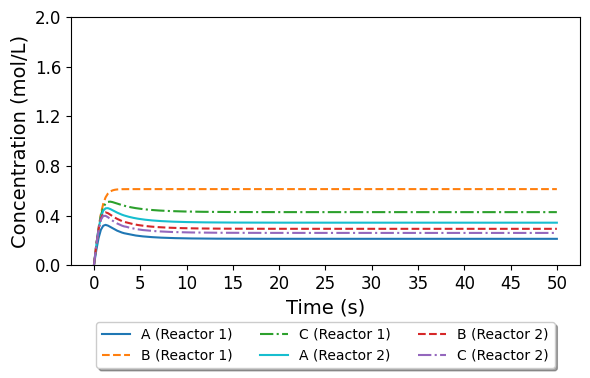

CA0 =  0.0
CB0 =  0.0


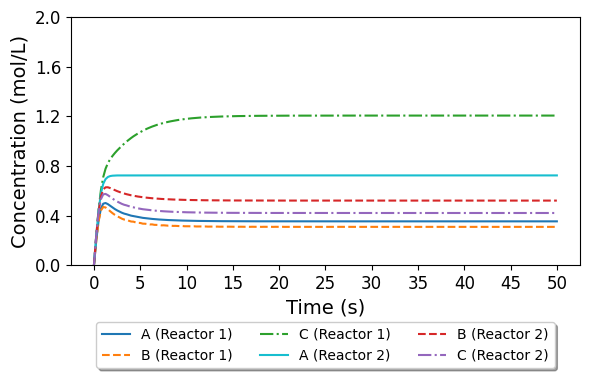

CA0 =  0.0
CB0 =  0.0


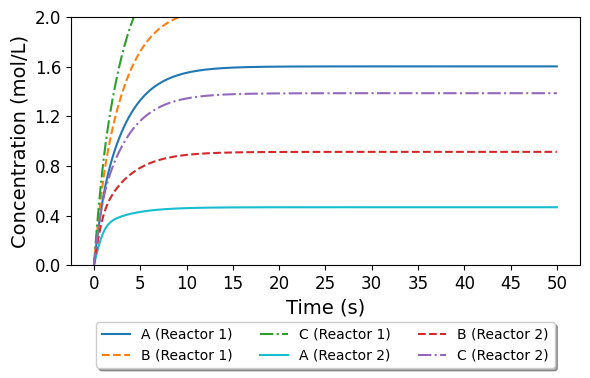

CA0 =  0.0
CB0 =  0.0


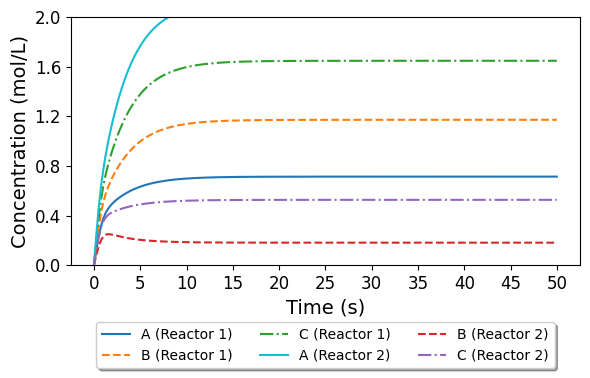

CA0 =  0.0
CB0 =  0.0


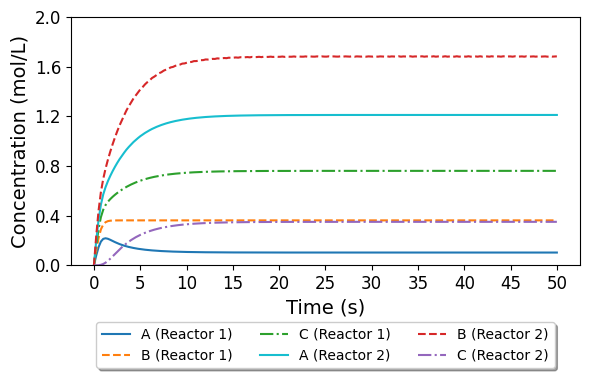

CA0 =  0.0
CB0 =  0.0


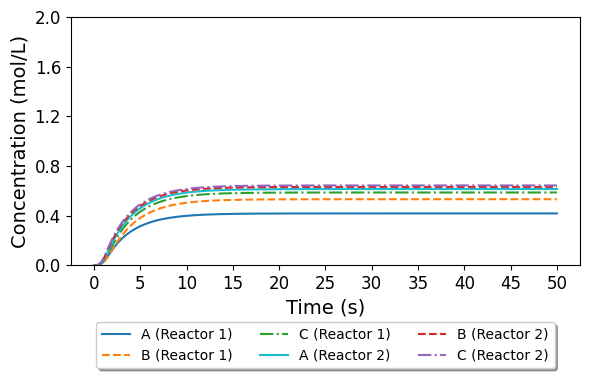

CA0 =  0.0
CB0 =  0.0


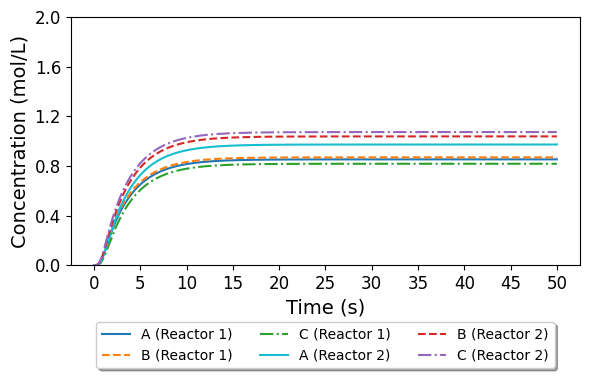

CA0 =  0.0
CB0 =  0.0


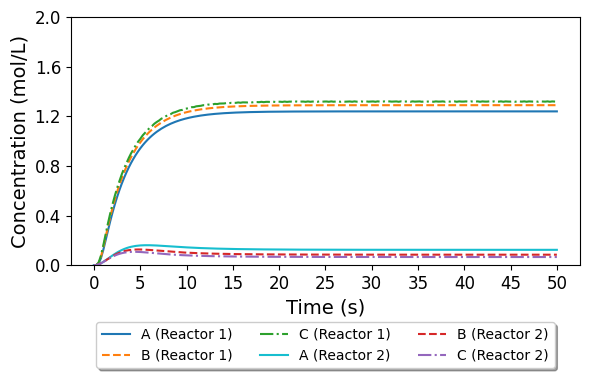

CA0 =  0.0
CB0 =  0.0


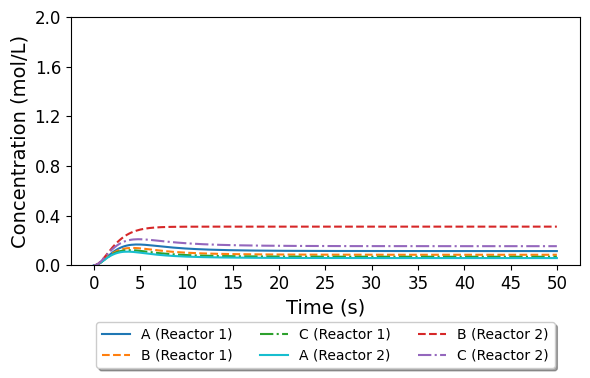

CA0 =  0.0
CB0 =  0.0


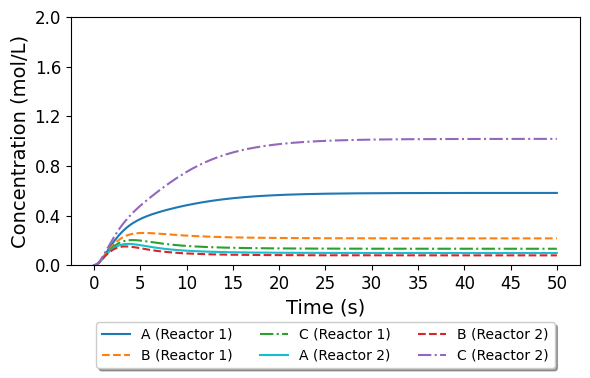

CA0 =  0.0
CB0 =  0.0


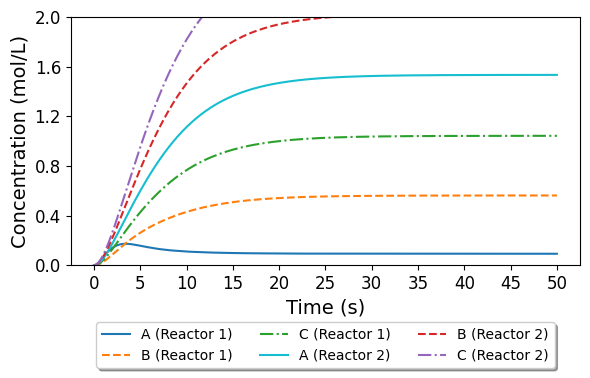

CA0 =  0.0
CB0 =  0.0


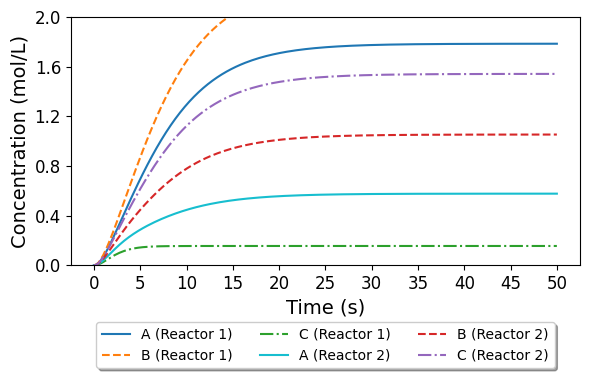

CA0 =  0.0
CB0 =  0.0


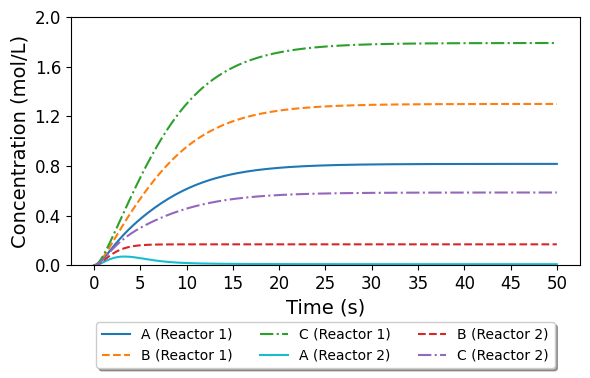

CA0 =  0.0
CB0 =  0.0


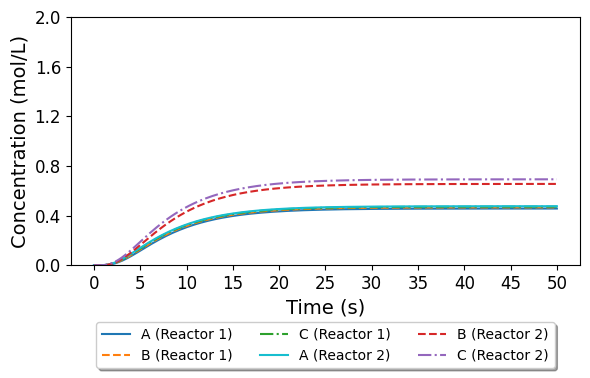

CA0 =  0.0
CB0 =  0.0


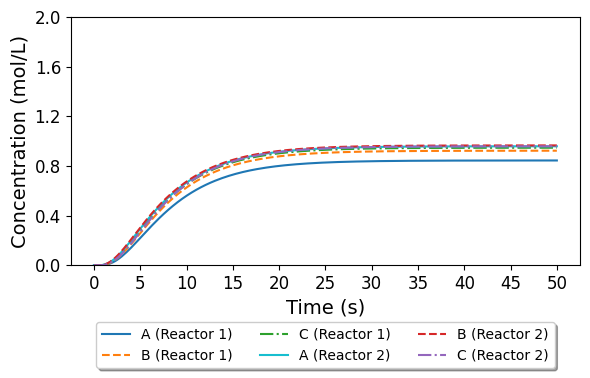

CA0 =  0.0
CB0 =  0.0


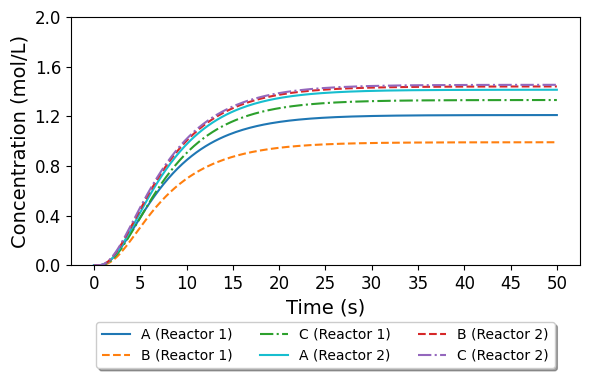

In [113]:
for i in range(num_combinations):
    print ('CA0 = ', conc_data[0,i,0])
    print ('CB0 = ', conc_data[0,i,1])
    plot_concentration_over_time(conc_data_new[:,i,:], labels, sol.t, colors, linestyles, max_value = 2, min_value=0, tick=0.4)

In [114]:
# Testing computation time needed
solvers = ["RK45", "Radau", "BDF", "LSODA"]
results = {}
n_runs = 10

# Benchmark each solver with timeit
for method in solvers:
    def run_solver():
        solve_ivp(rhs_vector, t_span, y0, t_eval=t_eval, method=method)

    elapsed = timeit.timeit(run_solver, number=n_runs) / n_runs  # average of n_runs
    sol = solve_ivp(rhs_vector, t_span, y0, t_eval=t_eval, method=method)  # final solution
    results[method] = {"solution": sol, "time": elapsed}

# Print runtime summary
print(f"Solver runtimes (total over {n_runs} runs):")
for method, data in results.items():
    print(f"{method:6s}: {data['time']:.6f} s")

Solver runtimes (total over 10 runs):
RK45  : 0.040667 s
Radau : 0.286631 s
BDF   : 0.134708 s
LSODA : 0.136683 s


Solver runtimes (total over 25 runs):
RK45  : 0.175202 s
Radau : 0.268983 s
BDF   : 0.338112 s
LSODA : 0.090642 s\
\
Solver runtimes (total over 1 runs):
RK45  : 0.058336 s
Radau : 0.291591 s
BDF   : 0.125865 s
LSODA : 0.120229 s

In [115]:
print ('Comparison best vector and original computation times')
print ('Runge-Kutta vector / Runge-Kutta: ', 0.058/0.175)
print ('Runge-Kutta vector / LSODA: ',0.058/0.090)

Comparison best vector and original computation times
Runge-Kutta vector / Runge-Kutta:  0.33142857142857146
Runge-Kutta vector / LSODA:  0.6444444444444445


Parallelized case

In [97]:
# Def function for one case
def rhs_single(t, y, k, tau1, tau2):
    A0, B0, C0, A1, B1, C1, A2, B2, C2 = y

    # reaction rates
    r1 = k * A1**2 * B1
    r2 = k * A2**2 * B2

    # ODEs
    dA0 = 0.0
    dB0 = 0.0
    dC0 = 0.0

    dA1 = (A0 - A1)/tau1 - 2*r1
    dB1 = (B0 - B1)/tau1 - r1
    dC1 = (C0 - C1)/tau1 + r1

    dA2 = (A1 - A2)/tau2 - 2*r2
    dB2 = (B1 - B2)/tau2 - r2
    dC2 = (C1 - C2)/tau2 + r2

    return [dA0, dB0, dC0, dA1, dB1, dC1, dA2, dB2, dC2]

In [98]:
# Call solve_ivp for one case
def run_case(ca0, cb0, k, tau1, tau2, t_span, t_eval):
    # initial conditions
    y0 = [ca0, cb0, 0.0,   # feed
          0.0, 0.0, 0.0,   # reactor 1
          0.0, 0.0, 0.0]   # reactor 2

    sol = solve_ivp(rhs_single, t_span, y0, args=(k, tau1, tau2),
                    t_eval=t_eval, method="RK45")
    return sol

In [99]:
# Import library
from joblib import Parallel, delayed

t_span = (0, 50)
t_eval = np.linspace(*t_span, 200)

# Call parallelization for each case
results = Parallel(n_jobs=-1)(   # -1 uses all cores
    delayed(run_case)(ca, cb, k, tau1, tau2, t_span, t_eval)
    for ca, cb in zip(CA0, CB0)
)

In [100]:
#Organize results
outlet_A2 = [sol.y[6, -1] for sol in results]
outlet_B2 = [sol.y[7, -1] for sol in results]
outlet_C2 = [sol.y[8, -1] for sol in results]

In [101]:
all_data = np.array([sol.y.T for sol in results])
# shape: (n_cases, n_times, 9 species)
all_data = all_data.transpose(1, 0, 2)

In [102]:

# Your setup
solvers = ["RK45", "Radau", "BDF", "LSODA"]
results = {}
n_runs = 10

CA0 = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
CB0 = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
CA_grid, CB_grid = np.meshgrid(CA0, CB0)
pairs = list(zip(CA_grid.flatten(), CB_grid.flatten()))

t_span = (0, 10)
t_eval = np.linspace(*t_span, 200)
y0 = np.ones(9)  # example IC

def rhs_vector(t, y, CA0, CB0):
    dydt = np.zeros_like(y)
    dydt[0] = -CA0 * y[0]
    dydt[1] = CB0 * y[0]
    return dydt

def run_solver_for_method(method):
    all_solutions = []
    for CA, CB in pairs:
        sol = solve_ivp(rhs_vector, t_span, y0, t_eval=t_eval, method=method, args=(CA, CB))
        all_solutions.append(sol.y.T)  # shape (200,9)
    all_data = np.array(all_solutions)  # shape (25,200,9)
    all_data = all_data.transpose(1, 0, 2)  # shape (200,25,9)
    return all_data

# Benchmark each solver with timeit
for method in solvers:
    def run_solver():
        return run_solver_for_method(method)

    elapsed = timeit.timeit(run_solver, number=n_runs) / n_runs
    final_data = run_solver()

    results[method] = {"data": final_data, "time": elapsed}

# Print runtime summary
print(f"Solver runtimes (average of {n_runs} runs):")
for method, data in results.items():
    print(f"{method:6s}: {data['time']:.6f} s")
    print(f"  Final data shape: {data['data'].shape}")

Solver runtimes (average of 10 runs):
RK45  : 0.062464 s
  Final data shape: (200, 25, 9)
Radau : 0.229112 s
  Final data shape: (200, 25, 9)
BDF   : 0.325007 s
  Final data shape: (200, 25, 9)
LSODA : 0.063025 s
  Final data shape: (200, 25, 9)
